# Phasespace

This is an example of plotting phase space distributions.
First, create a simple line, a tracker and a particle set:

In [1]:
import xtrack as xt
import xpart as xp
import xplt
import numpy as np

np.random.seed(43543557)

In [2]:
## Generate a simple 6-fold symmetric FODO lattice
n = 6
fodo = [
    xt.Multipole(length=0.2, knl=[0, +0.2], ksl=[0, 0]),
    xt.Drift(length=1.0),
    xt.Multipole(length=0.2, knl=[0, -0.2], ksl=[0, 0]),
    xt.Drift(length=1.0),
    xt.Multipole(length=1.0, knl=[2 * np.pi / n], hxl=[2 * np.pi / n]),
    xt.Drift(length=1.0),
]
line = xt.Line(elements=n * fodo)
tracker = xt.Tracker(line=line)

In [3]:
## Generate particles
line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=1e9)
nparticles = int(1e4)

# Transverse distribution (gaussian)
norm_emitt_x = 2e-6  # normalized 1-sigma emittance in m*rad (=beta*gamma*emitt_x)
norm_emitt_y = 1e-6  # normalized 1-sigma emittance in m*rad (=beta*gamma*emitt_y)
x, px = xp.generate_2D_gaussian(nparticles)
y, py = xp.generate_2D_gaussian(nparticles)

# Longitudinal distribution (coasting beam)
rel_momentum_spread = 1e-4  # relative momentum spread ( P/p0 - 1 )
zeta = line.get_length() * np.random.uniform(-0.5, 0.5, nparticles)
delta = rel_momentum_spread * xp.generate_2D_gaussian(nparticles)[0]

particles = xp.build_particles(
    tracker=tracker,
    particle_ref=line.particle_ref,
    x_norm=x,
    px_norm=px,
    nemitt_x=norm_emitt_x,
    y_norm=y,
    py_norm=py,
    nemitt_y=norm_emitt_y,
    method="4d",  # for twiss (default is 6d, won't work without a cavity)
    zeta=zeta,
    delta=delta,
)

## Default phasespace plot

Create a default {class}`PhasespacePlot <xplot.phasespace.PhaseSpacePlot>`:

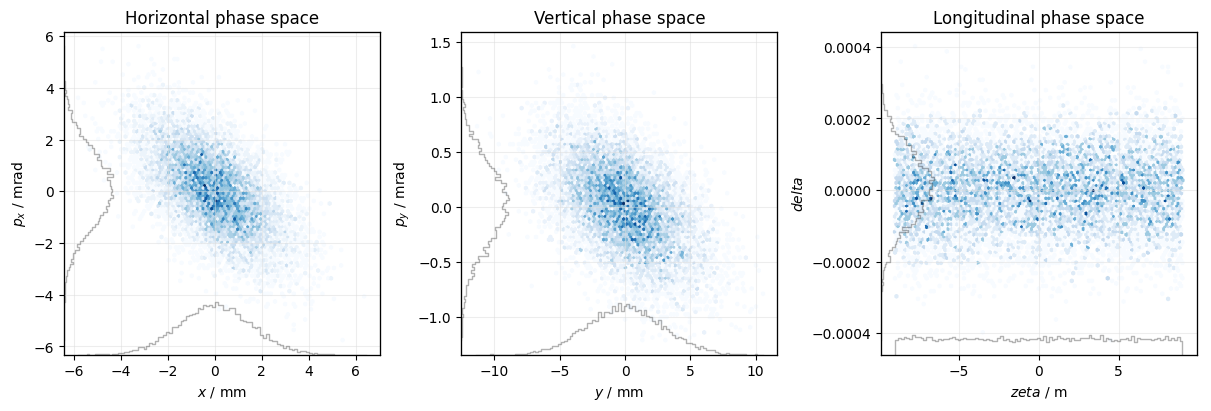

In [4]:
plot = xplt.PhaseSpacePlot(particles)

## Customisation

Use the parameter `kind` to specify what is plotted and add some ellipses to indicate standard deviation and percentiles. See {class}`PhasespacePlot <xplt.phasespace.PhaseSpacePlot>` for details.

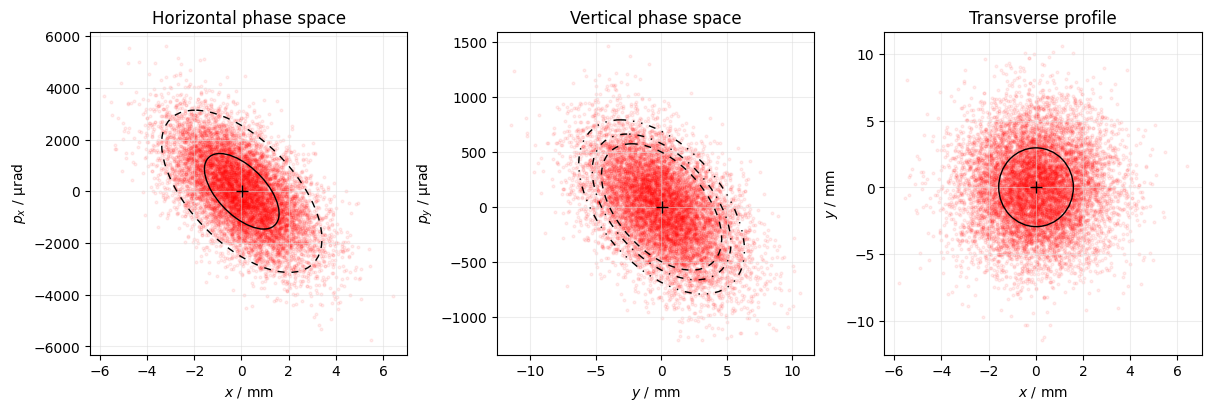

In [5]:
plot = xplt.PhaseSpacePlot(
    particles,
    kind="x,y,x-y",
    plot="scatter",
    color="#F001",  # scatter plot with semi-transparent color
    projections=False,  # No projections onto axes
    display_units=dict(p="urad"),  # p as shorthand for px and py
    mean=True,  # show mean cross for all
    std=[True, None, True],  # show std ellipse for first and last
    percentiles=[[90], [70, 80, 90], None],  # show some percentile ellipses
)
plot.ax[2].set(title="Transverse profile");

```{tip}
The `kind=` parameter accepts abbreviations for common pairs, e.g. `x` for `x-px`, `z` for `zeta-delta` or `Y` for `Y-Py`
```

```{tip}
Most parameters accept a list of values to specify different values for each subplot
```

## Normalized coordinates

Calculate twiss parameters for normalization:

In [6]:
tw = tracker.twiss(
    method="4d",
    at_s=np.unique(particles.s),  # twiss at location of particles
)

Use uppercase letters for normalized coordinates:

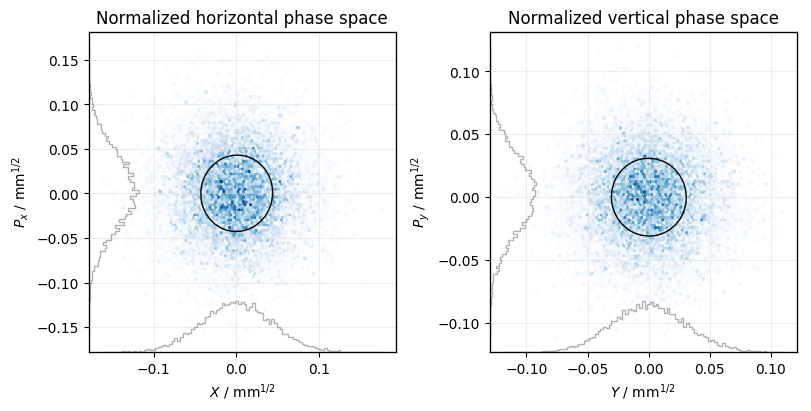

In [7]:
plot = xplt.PhaseSpacePlot(particles, kind="X,Y", twiss=tw, std=True)

## Monitor data

Track the particle for a couple of turns:

In [8]:
tracker.track(particles, num_turns=100, turn_by_turn_monitor=True)

Use `mask=` to select a subset of the data to plot, e.g. a single turn:

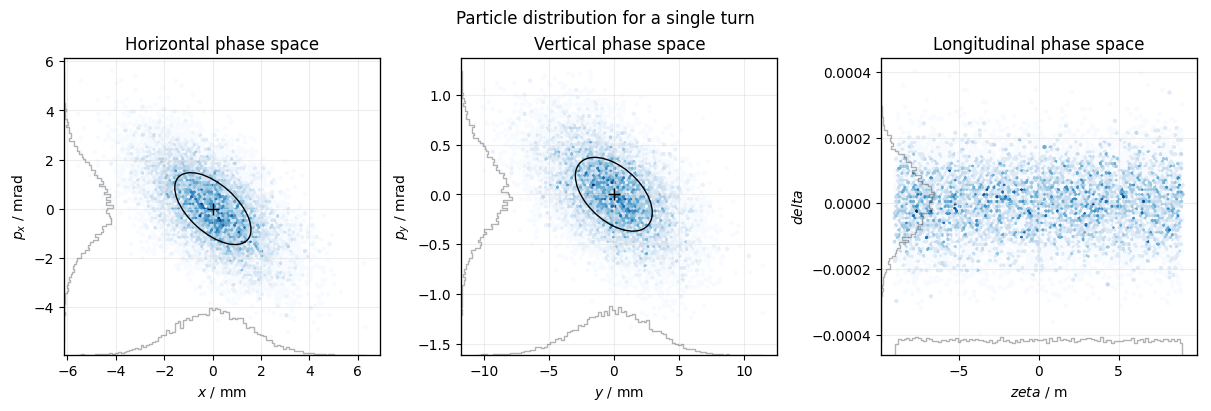

In [9]:
plot = xplt.PhaseSpacePlot(
    tracker.record_last_track,
    mask=(slice(None), 83),  # select all particles and turn 83
    mean=(1, 1, 0),
    std=(1, 1, 0),
)
plot.fig.suptitle("Particle distribution for a single turn");

Use `masks=` to set a different mask for each subplot:

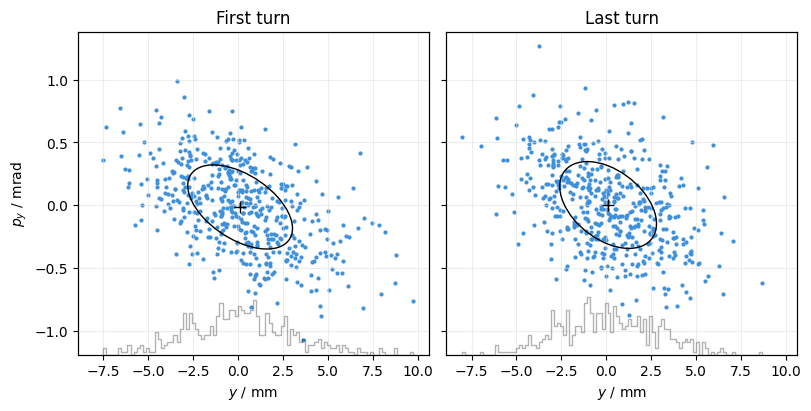

In [10]:
plot = xplt.PhaseSpacePlot(
    tracker.record_last_track,
    kind="y,y",
    titles=("First turn", "Last turn"),
    sharex="all",
    sharey="all",
    masks=[  # select particles at first and last turn
        (slice(500), 0),
        (slice(500), -1),
    ],
    projections="x",
    mean=True,
    std=True,
)
plot.ax[1].set(ylabel=None);

Plot the trace of some particles:

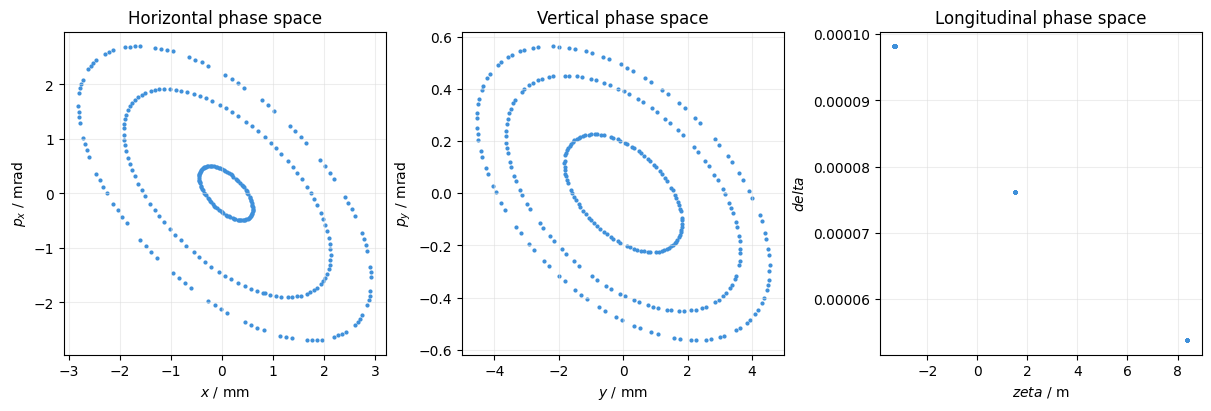

In [11]:
plot = xplt.PhaseSpacePlot(
    tracker.record_last_track,
    mask=([17, 18, 21], slice(None)),  # select particles 17,18,21 and all turns
    projections=False,
)

Plot the trace of some particles as distinct plots on the same axis:

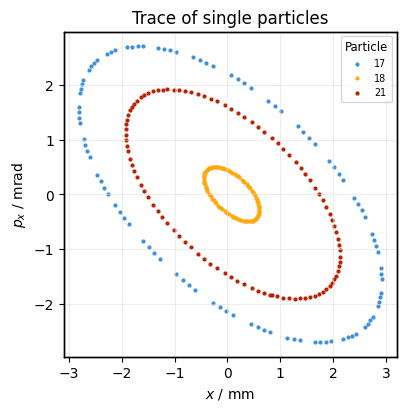

In [12]:
particle_indices = (17, 18, 21)
ax = None

for particle_i in particle_indices:
    plot = xplt.PhaseSpacePlot(
        tracker.record_last_track,
        mask=(particle_i, slice(None)),  # select particle i and all turns
        kind="x",
        titles=("Trace of single particles",),
        ax=ax,  # draw on same plot as before
    )
    ax = plot.ax

plot.ax[0].legend(particle_indices, title="Particle");

-----------------
```{seealso}
- {class}`xplt.phasespace`
```